# Hypothesis 1

There is a relation between EEG signal and 3 levels of stress.

For each pair of person and task, there are 3 distinct groups of EEG signals representing the 3 levels of stress.

In [72]:
from utils import *
import pandas as pd
import mne
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

In [73]:
participant_name = "nutcha"
task = "mathcontrol" 
# task = "mathstress"
files = glob(f"data/{participant_name}_{task}_*.csv")
if(len(files) != 1):
    raise ValueError(f"glob found these files. {files}")

pandasRaw = pd.read_csv(files[0], dtype={'Marker':str})
pandasRaw,marker_idx = marker_converter_1(pandasRaw)
pandasRaw

,Fp1,Fp2,F3,F4,F7,F8,O1,O2,Marker
0,13601.416,14019.104,8651.623,20291.449,13364.712,2385.579,-1963.109,7528.604,0
1,13608.167,14024.289,8656.630,20285.705,13375.910,2384.909,-1958.281,7538.707,0
2,13614.425,14031.129,8661.726,20278.822,13390.640,2383.881,-1956.806,7545.748,0
3,13620.349,14034.683,8656.809,20277.369,13388.337,2386.451,-1962.617,7535.533,0
4,13623.299,14045.277,8645.118,20278.262,13371.528,2391.726,-1974.151,7510.790,0
...,...,...,...,...,...,...,...,...,...
220447,12531.751,14473.269,8232.259,19328.627,13902.740,3972.531,-1936.466,7300.817,0
220448,12537.831,14491.150,8234.539,19340.338,13893.822,3974.006,-1923.122,7309.110,0
220449,12536.355,14490.837,8229.107,19333.768,13899.187,3969.983,-1919.970,7307.210,0
220450,12543.531,14483.976,8222.179,19326.414,13904.729,3973.403,-1926.609,7308.774,0


In [74]:
for marker in pandasRaw['Marker'].unique():
    print(marker, marker_idx[marker])

0 0
1 math,LowStress,start
2 math,LowStress,S
3 math,LowStress,T
4 math,LowStress,F
5 fixation,None,None
6 math,MildStress,start
7 math,MildStress,S
8 math,MildStress,T
9 math,MildStress,F
10 math,HigherStress,start
11 math,HigherStress,T
12 math,HigherStress,F
13 math,HigherStress,S


In [75]:
raw = dataframe_to_raw(pandasRaw, sfreq=250)

In [76]:
# Preprocess
raw.notch_filter([50,100],filter_length='auto', phase='zero', verbose=False) # Line power
raw.filter(1, None, verbose=False) # Slow drift
pass
# ica = mne.preprocessing.ICA(n_components=8, max_iter='auto')
# ica.fit(raw, verbose=False)
# raw = ica.apply(raw, verbose=False)

In [77]:
events = mne.find_events(raw, stim_channel='Marker', initial_event=True, verbose=False, uint_cast=False)
marker_names = ['math,LowStress,start',
                'math,LowStress,T',
                'math,LowStress,F',
                'math,LowStress,S',
                'math,MildStress,start',
                'math,MildStress,T',
                'math,MildStress,F',
                'math,MildStress,S',
                'math,HigherStress,start',
                'math,HigherStress,T',
                'math,HigherStress,F',
                'math,HigherStress,S',
                'fixation,None,None']
interested_marker_names = ['math,LowStress,start','math,MildStress,start','math,HigherStress,start','fixation,None,None']

interested_markers = [ marker_idx.index(name) for name in interested_marker_names ]

for name in marker_names:
    task, level, m = name.split(',')
    if(name not in marker_idx): continue
    number = sum(events[::,2] == marker_idx.index(name))
    if(m == 'start'): print(f"Number of {level} questions: {number}")
    if(m == 'T'): print(f"  Correct: {number}")
    if(m == 'F'): print(f"  Wrong: {number}")
    if(m == 'S'): print(f"  Slow: {number}")

uninterested_markers = list(set(np.unique(events[::,2])).difference(set(interested_markers)))
for marker in uninterested_markers:
    events = np.delete(events, np.argwhere(events[:,2] == marker), axis=0) 

Number of LowStress questions: 65
  Correct: 48
  Wrong: 7
  Slow: 10
Number of MildStress questions: 38
  Correct: 21
  Wrong: 11
  Slow: 6
Number of HigherStress questions: 15
  Correct: 8
  Wrong: 6
  Slow: 1


In [78]:
# Here we only get the event that indicate the begining of the block and fixation.
interested_events = []
prev_is_Low_start = False
prev_is_Mil_start = False
prev_is_Hig_start = False
Low_start = marker_idx.index('math,LowStress,start')
Mil_start = marker_idx.index('math,MildStress,start')
Hig_start = marker_idx.index('math,HigherStress,start')

for event in events:
    if(event[2] == Low_start and prev_is_Low_start == False):
        interested_events.append(list(event))
        prev_is_Low_start = True
    elif(event[2] != Low_start):
        prev_is_Low_start = False

    if(event[2] == Mil_start and prev_is_Mil_start == False):
        interested_events.append(list(event))
        prev_is_Mil_start = True
    elif(event[2] != Mil_start):
        prev_is_Mil_start = False

    if(event[2] == Hig_start and prev_is_Hig_start == False):
        interested_events.append(list(event))
        prev_is_Hig_start = True
    elif(event[2] != Hig_start):
        prev_is_Hig_start = False


    if(event[2] == marker_idx.index('fixation,None,None')):
        interested_events.append(list(event))
    # print(event)
interested_events = np.array(interested_events)
interested_events

array([[  2615,      0,      1],
       [ 13105,      0,      5],
       [ 15871,      0,      1],
       [ 25906,      0,      5],
       [ 28672,      0,      1],
       [ 38968,      0,      5],
       [ 41733,      0,      1],
       [ 51983,      0,      5],
       [ 70772,      0,      6],
       [ 81593,      0,      5],
       [ 84359,      0,      6],
       [ 95196,      0,      5],
       [ 97962,      0,      6],
       [108572,      0,      5],
       [111337,      0,      6],
       [122097,      0,      5],
       [140900,      0,     10],
       [151647,      0,      5],
       [154412,      0,     10],
       [169533,      0,      5],
       [172298,      0,     10],
       [182594,      0,      5],
       [185360,      0,     10],
       [198872,      0,      5]])

In [79]:
# Here we split the block into chuncks
chunck_size = 5 # second

m_start = interested_events[0::2]
m_stop = interested_events[1::2]
chunck_events = []
for index, (start, stop) in enumerate(zip(m_start, m_stop)):
    # [time_stamp, _, marker]
    a = start[2] in interested_markers
    b = stop[2] == marker_idx.index('fixation,None,None')
    if((a and b) == False):
        raise ValueError(f"at {index}, found unexpected marker order. start='{marker_idx[start[2]]}' stop='{marker_idx[stop[2]]}'")
    for i in range(start[0], start[0]+(30*250)+1, chunck_size*250):
        if(i + chunck_size*250 >= stop[0]):
            raise ValueError(f"start stop is incorrect.")
        chunck_events.append([i,0,start[2]])

chunck_events = np.array(chunck_events)
num_low = sum(chunck_events[::,2] == marker_idx.index('math,LowStress,start'))
num_mil = sum(chunck_events[::,2] == marker_idx.index('math,MildStress,start'))
num_hig = sum(chunck_events[::,2] == marker_idx.index('math,HigherStress,start'))
if(num_low != num_mil or num_mil != num_hig):
    raise ValueError(f"The number of chuncked events is not equal. LowStress={num_low} MildStress={num_mil} HigherStress={num_hig}")
print(f"Number of samples of each block: {num_low}")
num_chunck = num_low


Number of samples of each block: 28


In [80]:
t_start, t_stop = 0.3, 4.8
epochs = mne.Epochs(raw, chunck_events, tmin=t_start, tmax=t_stop, baseline=(t_start,t_stop), verbose=False)

In [81]:
# 0,4 Delta
# 4,8 Theta
# 8,16 Alpha ***
# 16,32 Beta 
# 32,64 Noisy Gamma
# 64,128 Noisy Signal
# frequencies = np.arange(8, 32+1, 8)
frequencies = np.array([10,11,12,13,14])
features = []
labels = []
for index, evoked in enumerate(epochs.iter_evoked()):
    event = evoked.comment
    tfr_obj = mne.time_frequency.tfr_morlet(evoked, n_cycles=3, return_itc=False, freqs=frequencies, decim=3)
    # (channel,freq,time-window)
    coeff = tfr_obj.data 
    # (freq,time-window)
    coeff = coeff.mean(axis=0)
    # alpha mean
    coeff = coeff.mean()
    features.append(coeff)
    labels.append(event)
# features = np.array(features)
# features.shape

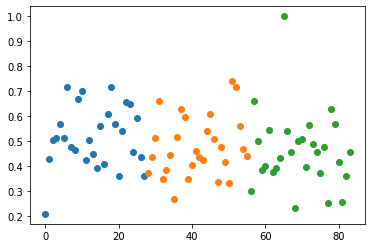

In [82]:
from sklearn.preprocessing import normalize
f_norm = normalize(np.array(features).reshape(-1,1), axis=0, norm='max')
# f_norm = np.array(features).reshape(-1,1)
plt.scatter(range(num_chunck*0,num_chunck*1),f_norm[num_chunck*0:num_chunck*1])
plt.scatter(range(num_chunck*1,num_chunck*2),f_norm[num_chunck*1:num_chunck*2])
plt.scatter(range(num_chunck*2,num_chunck*3),f_norm[num_chunck*2:num_chunck*3])
# plt.ylim(0,0.015)